<a href="https://colab.research.google.com/github/axel-sirota/practical-nlp/blob/main/2-classification/Practical_NLP_6_NewsClassification_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Oct 14 17:05:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install textblob 'gensim==4.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import pickle
from tensorflow.nn import leaky_relu

import re
import warnings
from sklearn.model_selection import train_test_split
from textblob import TextBlob


TRACE = False
embedding_dim = 50
epochs=100
batch_size = 250
corpus_size=25000
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
%%writefile get_data.sh
if [ ! -f yelp.csv ]; then
  wget -O news.csv https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
fi

if [ ! -f emb_word2vec_format.txt ]; then
    wget -O emb_word2vec_format.txt https://www.dropbox.com/s/cqoacnovxsq1zoe/emb_word2vec_format.txt?dl=0
fi

Overwriting get_data.sh


In [5]:
!bash get_data.sh

--2022-10-14 17:05:09--  https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/352x7xzivf60zgc/news.csv [following]
--2022-10-14 17:05:10--  https://www.dropbox.com/s/raw/352x7xzivf60zgc/news.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb388e46628f4c47a34ed31956d.dl.dropboxusercontent.com/cd/0/inline/Bu3Eczg71HEPbqnyrtbhUFlKKRgPUrpbLfvOebBVMwHJiO-ZNQA5D1ZtIHl63VKmvsQhstjSli1WlCPs3isWx_asz4rcA4STtowz1SgUziMKnA35bJ98tw6mBxZCeFXWY9zQ6vS4WepE6Bqd5hrgubXUWqhCSKKnqC68fI0kTu52Ig/file# [following]
--2022-10-14 17:05:10--  https://ucb388e46628f4c47a34ed31956d.dl.dropboxusercontent.com/cd/0/inline/Bu3Eczg71HEPbqnyrtbhUFlKKRgPUrpbLfvOebBVMwHJiO-ZNQA5D1ZtIHl63VKmvsQhstjSli1WlCPs3isW

In [6]:
path = './news.csv'
news = pd.read_csv(path, header=0).sample(n=corpus_size).reset_index(drop=True)

In [7]:
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = ' '.join(gensim.utils.simple_preprocess(text))
    return text

In [8]:
news.title.apply(preprocess_text)
news

,category,title
0,Business,"BBC set for major shake-up, claims newspaper"
1,Business,Marsh averts cash crunch
2,Sports,"Jeter, Yankees Look to Take Control (AP)"
3,Sci/Tech,Flying the Sun to Safety
4,Business,Stocks Seen Flat as Nortel and Oil Weigh
...,...,...
24995,Business,Wal-Mart Clarifies Policy Regarding Unions (AP)
24996,Sci/Tech,VIEWPOINT: Better Russian planning would preve...
24997,Sports,"No. 6 Syracuse 56, Princeton 45"
24998,Sports,"USC, Oklahoma Still 1-2, Auburn Third in BCS"


In [9]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('emb_word2vec_format.txt')

In [10]:
news['label'] = news.category.map({'Business': 0, 'Sports': 1, 'Sci/Tech': 2, 'World': 3})

weights = tf.constant(word2vec_model.vectors)
vocab_size = len(word2vec_model.index_to_key)

In [11]:
def get_maximum_review_length(df):
    maximum = 0
    for ix, row in df.iterrows():
        candidate = len(tokenizer(row.title))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(news)

In [12]:
X = np.zeros((len(news), maximum))
for index, row in news.iterrows():
    ix = 0
    for word in tokenizer(row.title):
        if word not in word2vec_model:
            representation = 0
        else:
            representation = word2vec_model.index_to_key.index(word)
        X[index, ix] = representation
        ix += 1
y = news.label

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)
y_train = tf.one_hot(tf.constant(y_train), 4)
y_test = tf.one_hot(tf.constant(y_test), 4)

In [14]:
X_train[0]

<tf.Tensor: shape=(21,), dtype=float64, numpy=
array([    0.,     0.,  4948., 29646.,   672.,   194.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.])>

In [15]:
weights.shape

TensorShape([400000, 50])

In [16]:
model = Sequential()
model.add(Embedding(input_dim=weights.shape[0], output_dim=50, input_length=maximum, embeddings_initializer=Constant(weights), trainable=False))
model.add(Dense(100, activation=leaky_relu))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(None, embedding_dim,)))
model.add(Dense(50, activation=leaky_relu))
model.add(Dense(4, activation='softmax'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', steps_per_execution=len(X_train)//batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 50)            20000000  
                                                                 
 dense (Dense)               (None, 21, 100)           5100      
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 20,010,354
Trainable params: 10,354
Non-trainable params: 20,000,000
_________________________________________________________________


In [18]:
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), workers=5)

Epoch 1/100
80/80 [==============================] - 2s 24ms/step - loss: 1.3452 - val_loss: 1.2908
Epoch 2/100
80/80 [==============================] - 0s 2ms/step - loss: 1.1916 - val_loss: 1.1443
Epoch 3/100
80/80 [==============================] - 0s 2ms/step - loss: 1.1030 - val_loss: 1.0968
Epoch 4/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0856 - val_loss: 1.1072
Epoch 5/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0778 - val_loss: 1.0809
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0743 - val_loss: 1.0782
Epoch 7/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0699 - val_loss: 1.0739
Epoch 8/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0629 - val_loss: 1.0747
Epoch 9/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0666 - val_loss: 1.0778
Epoch 10/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0614 - val_loss: 1.0775
Epoch 11

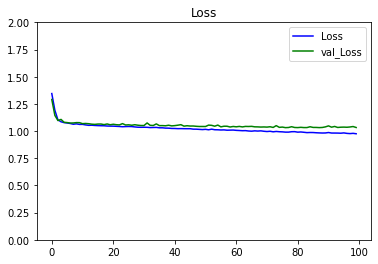

In [20]:
import matplotlib.pyplot as plt

# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=2.0)